In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/AUEB/MURA-v1.1.zip" -d /content/


In [ ]:
import pandas as pd

df = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df.head())


  MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...                 
2  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...                 


In [ ]:

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv')
print(df_train.columns)


Index(['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'], dtype='object')


In [ ]:
import pandas as pd
import os

df_train = pd.read_csv('/content/MURA-v1.1/train_image_paths.csv', header=None)
df_train.columns = ['image_path']
df_train['path'] = df_train['image_path'].apply(lambda x: os.path.join('/content', x))
df_train['label'] = df_train['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_train['body_part'] = df_train['image_path'].apply(lambda x: x.split('/')[2])  # e.g., 'XR_SHOULDER'


In [ ]:
from sklearn.model_selection import train_test_split

# Create a stratification key combining body part + label
df_train['stratify_group'] = df_train['body_part'] + "_" + df_train['label'].astype(str)

# Stratified 80/20 split
df_train_final, df_val_final = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['stratify_group']
)

In [ ]:
# Dropping the helper column
df_train_final = df_train_final.drop(columns=['stratify_group'])
df_val_final = df_val_final.drop(columns=['stratify_group'])

In [ ]:
df_test = pd.read_csv('/content/MURA-v1.1/valid_image_paths.csv', header=None)
df_test.columns = ['image_path']
df_test['path'] = df_test['image_path'].apply(lambda x: os.path.join('/content', x))
df_test['label'] = df_test['image_path'].apply(lambda x: 1 if 'positive' in x else 0)
df_test['body_part'] = df_test['image_path'].apply(lambda x: x.split('/')[2])  # e.g., XR_WRIST


In [ ]:
# Encode body_part as part_idx for conditioning
body_parts = sorted(df_train_final['body_part'].unique())  # Ensure consistent order
part_to_index = {part: idx for idx, part in enumerate(body_parts)}

for df in [df_train_final, df_val_final, df_test]:
    df['part_idx'] = df['body_part'].map(part_to_index)

In [ ]:
# Distribution and Sanity Check

print("Training set:")
print(df_train_final['body_part'].value_counts(normalize=True))

print("\nValidation set:")
print(df_val_final['body_part'].value_counts(normalize=True))


Training set:
body_part
XR_WRIST       0.264960
XR_SHOULDER    0.227637
XR_HAND        0.150581
XR_FINGER      0.138695
XR_ELBOW       0.133974
XR_FOREARM     0.049582
XR_HUMERUS     0.034572
Name: proportion, dtype: float64

Validation set:
body_part
XR_WRIST       0.264874
XR_SHOULDER    0.227656
XR_HAND        0.150638
XR_FINGER      0.138821
XR_ELBOW       0.133931
XR_FOREARM     0.049579
XR_HUMERUS     0.034501
Name: proportion, dtype: float64


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch


class MuraDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        part_idx = self.df.loc[idx, 'part_idx']
        image = Image.open(img_path).convert("L")  # "L" = grayscale


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), torch.tensor(part_idx, dtype=torch.long)


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # for grayscale
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
from torch.utils.data import DataLoader

# Train
train_dataset = MuraDataset(df_train_final, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Validation
val_dataset = MuraDataset(df_val_final, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Test
test_dataset = MuraDataset(df_test, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## MultiTask Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50Multitask(nn.Module):
    def __init__(self, num_body_parts=7, embed_dim=32, pretrained=True):
        super(ResNet50Multitask, self).__init__()

        self.embed_dim = embed_dim

        # Load pretrained ResNet50 backbone
        self.backbone = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)

        # Modify first conv layer to accept grayscale input
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)



        # Freeze early layers
        for param in self.backbone.parameters():
            param.requires_grad = False
        for name, param in self.backbone.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True

        # Remove the original FC layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Body part embedding (only for fracture head)
        self.part_embed = nn.Embedding(num_body_parts, embed_dim)

        # Fracture classification head (uses embedding)
        self.fracture_head = nn.Sequential(
            nn.Linear(in_features + embed_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

        # Body part classification head (no embedding)
        self.bodypart_head = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_body_parts)
        )

    def forward(self, x, part_idx):
        features = self.backbone(x)  # shared features
        part_embedding = self.part_embed(part_idx)

        # Fracture classification: image + part embedding
        fracture_input = torch.cat((features, part_embedding), dim=1)
        out_fracture = self.fracture_head(fracture_input)

        # Body part classification: only image features
        out_bodypart = self.bodypart_head(features)

        return out_fracture, out_bodypart


## Define loss, optimizer, Scheduler

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Use CrossEntropyLoss for both tasks
fracture_loss_fn = nn.CrossEntropyLoss()
bodypart_loss_fn = nn.CrossEntropyLoss()

# Instantiate model
model = ResNet50Multitask(num_body_parts=len(part_to_index)).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


## Training and Validation Loops


In [ ]:
def train_one_epoch(model, loader, optimizer, fracture_loss_fn, bodypart_loss_fn):
    model.train()
    total_loss, correct_frac, correct_part = 0, 0, 0

    for images, labels, part_idxs in loader:
        images = images.to(device)
        labels = labels.to(device)
        part_idxs = part_idxs.to(device)

        optimizer.zero_grad()
        out_fracture, out_bodypart = model(images, part_idxs)

        loss_fracture = fracture_loss_fn(out_fracture, labels)
        loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
        loss = loss_fracture + loss_bodypart

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_frac += (out_fracture.argmax(1) == labels).sum().item()
        correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n



def validate(model, loader, fracture_loss_fn, bodypart_loss_fn):
    model.eval()
    total_loss, correct_frac, correct_part = 0, 0, 0

    with torch.no_grad():
        for images, labels, part_idxs in loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, out_bodypart = model(images, part_idxs)

            loss_fracture = fracture_loss_fn(out_fracture, labels)
            loss_bodypart = bodypart_loss_fn(out_bodypart, part_idxs)
            loss = loss_fracture + loss_bodypart

            total_loss += loss.item()
            correct_frac += (out_fracture.argmax(1) == labels).sum().item()
            correct_part += (out_bodypart.argmax(1) == part_idxs).sum().item()

    n = len(loader.dataset)
    return total_loss / len(loader), correct_frac / n, correct_part / n


## Training

In [ ]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5
epochs = 20

for epoch in range(epochs):
    train_loss, train_fracture_acc, train_part_acc = train_one_epoch(model, train_loader, optimizer, fracture_loss_fn, bodypart_loss_fn)
    val_loss, val_fracture_acc, val_part_acc = validate(model, val_loader, fracture_loss_fn, bodypart_loss_fn)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Frac Acc: {train_fracture_acc:.4f}, Part Acc: {train_part_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Frac Acc: {val_fracture_acc:.4f}, Part Acc: {val_part_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "resnet50_multitask.pt")
    else:
        early_stop_counter += 1
        print(f"Early stop patience: {early_stop_counter}/5")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1/20 | Train Loss: 0.9926, Frac Acc: 0.6935, Part Acc: 0.8689 | Val Loss: 0.7388, Frac Acc: 0.7252, Part Acc: 0.9462
Epoch 2/20 | Train Loss: 0.7212, Frac Acc: 0.7420, Part Acc: 0.9445 | Val Loss: 0.6624, Frac Acc: 0.7493, Part Acc: 0.9594
Epoch 3/20 | Train Loss: 0.6662, Frac Acc: 0.7558, Part Acc: 0.9552 | Val Loss: 0.6278, Frac Acc: 0.7647, Part Acc: 0.9618
Epoch 4/20 | Train Loss: 0.6299, Frac Acc: 0.7677, Part Acc: 0.9621 | Val Loss: 0.6103, Frac Acc: 0.7691, Part Acc: 0.9660
Epoch 5/20 | Train Loss: 0.6009, Frac Acc: 0.7730, Part Acc: 0.9660 | Val Loss: 0.6124, Frac Acc: 0.7694, Part Acc: 0.9624
Early stop patience: 1/5
Epoch 6/20 | Train Loss: 0.5750, Frac Acc: 0.7839, Part Acc: 0.9701 | Val Loss: 0.6064, Frac Acc: 0.7774, Part Acc: 0.9664
Epoch 7/20 | Train Loss: 0.5556, Frac Acc: 0.7884, Part Acc: 0.9734 | Val Loss: 0.5981, Frac Acc: 0.7786, Part Acc: 0.9684
Epoch 8/20 | Train Loss: 0.5413, Frac Acc: 0.7969, Part Acc: 0.9739 | Val Loss: 0.6033, Frac Acc: 0.7745, Part Acc

## Evaluation Fracture

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score

def evaluate_fracture_task(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels, part_idxs in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            part_idxs = part_idxs.to(device)

            out_fracture, _ = model(images, part_idxs)

            probs = torch.softmax(out_fracture, dim=1)[:, 1].cpu().numpy()
            preds = out_fracture.argmax(dim=1).cpu().numpy()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    print("Fracture Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))
    print("ROC AUC Score:", roc_auc_score(all_labels, all_probs))
    print("Cohen's Kappa Score:", cohen_kappa_score(all_labels, all_preds))


## Evaluation Body Part

In [ ]:
def evaluate_bodypart_task(model, loader, index_to_part=None):
    model.eval()
    all_parts = []
    all_preds = []

    with torch.no_grad():
        for images, _, part_idxs in loader:
            images = images.to(device)
            part_idxs = part_idxs.to(device)

            _, out_bodypart = model(images, part_idxs)
            preds = out_bodypart.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_parts.extend(part_idxs.cpu().numpy())

    print("\n--- Body Part Classification Report ---")
    if index_to_part:
        target_names = [index_to_part[i] for i in sorted(set(all_parts))]
    else:
        target_names = None

    print(classification_report(all_parts, all_preds, target_names=target_names, digits=4))


In [ ]:
# In case it's not already defined in current scope
index_to_part = {v: k for k, v in part_to_index.items()}

# Load model
model.load_state_dict(torch.load("resnet50_multitask.pt"))

# Evaluate fracture classification and body part classification
evaluate_fracture_task(model, test_loader)
evaluate_bodypart_task(model, test_loader, index_to_part=index_to_part)


Fracture Classification Report:
              precision    recall  f1-score   support

           0     0.6967    0.9244    0.7945      1667
           1     0.8721    0.5614    0.6831      1530

    accuracy                         0.7507      3197
   macro avg     0.7844    0.7429    0.7388      3197
weighted avg     0.7806    0.7507    0.7412      3197

ROC AUC Score: 0.8237497598519511
Cohen's Kappa Score: 0.4930702268343562

--- Body Part Classification Report ---
              precision    recall  f1-score   support

    XR_ELBOW     0.9131    0.9720    0.9417       465
   XR_FINGER     0.9411    0.9696    0.9551       461
  XR_FOREARM     0.9101    0.8405    0.8739       301
     XR_HAND     0.9649    0.9565    0.9607       460
  XR_HUMERUS     0.9810    0.8958    0.9365       288
 XR_SHOULDER     0.9807    0.9911    0.9859       563
    XR_WRIST     0.9667    0.9697    0.9682       659

    accuracy                         0.9531      3197
   macro avg     0.9511    0.9422    0

# Visuals

In [ ]:
from graphviz import Digraph

def resnet50_multitask_architecture():
    dot = Digraph(comment='ResNet50 Multi-task Architecture')
    dot.attr(rankdir='TB', splines='spline', nodesep='0.6', ranksep='0.5')

    # Input & Part index
    dot.node('input', 'Input Image\n(224×224)', shape='ellipse', style='filled', fillcolor='#DDEEFF')
    dot.node('part_idx', 'Body Part Index\n(int)', shape='ellipse', style='filled', fillcolor='#DDEEFF')

    # Image path
    dot.node('conv', 'Conv2d(1 → 64)', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('resnet', 'ResNet50 Backbone\n(frozen except layer4)', shape='box', style='filled', fillcolor='#A3C1DA')
    dot.node('gap', 'Global Avg Pool\n→ (B, 2048)', shape='box', style='filled', fillcolor='#A3C1DA')

    # Embedding path
    dot.node('embed', 'Embedding Layer\n(num_parts → 32)', shape='box', style='filled', fillcolor='#C7E9C0')

    # Part prediction
    dot.node('body_fc1', 'Linear(2048 → 128)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('body_fc2', 'Linear(128 → 7)\nPart Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Merge
    dot.node('concat', 'Concatenate\n[Features + Part Embedding]', shape='diamond', style='filled', fillcolor='#FBE8A6')

    # Fracture classification head
    dot.node('fracture_fc1', 'Linear(2080 → 512)\nBN + ReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc2', 'Linear(512 → 256)\nReLU + Dropout', shape='box', style='filled', fillcolor='#FDD9D9')
    dot.node('fracture_fc3', 'Linear(256 → 2)\nFracture Output', shape='box', style='filled', fillcolor='#FFCCCC')

    # Connections
    dot.edge('input', 'conv')
    dot.edge('conv', 'resnet')
    dot.edge('resnet', 'gap')
    dot.edge('gap', 'body_fc1')
    dot.edge('body_fc1', 'body_fc2')
    dot.edge('gap', 'concat')
    dot.edge('part_idx', 'embed')
    dot.edge('embed', 'concat')
    dot.edge('concat', 'fracture_fc1')
    dot.edge('fracture_fc1', 'fracture_fc2')
    dot.edge('fracture_fc2', 'fracture_fc3')

    return dot

# Generate and view
resnet_diagram = resnet50_multitask_architecture()
resnet_diagram.render(filename='resnet50_multitask_architecture', format='png', cleanup=False)
resnet_diagram.view()


'resnet50_multitask_architecture.pdf'

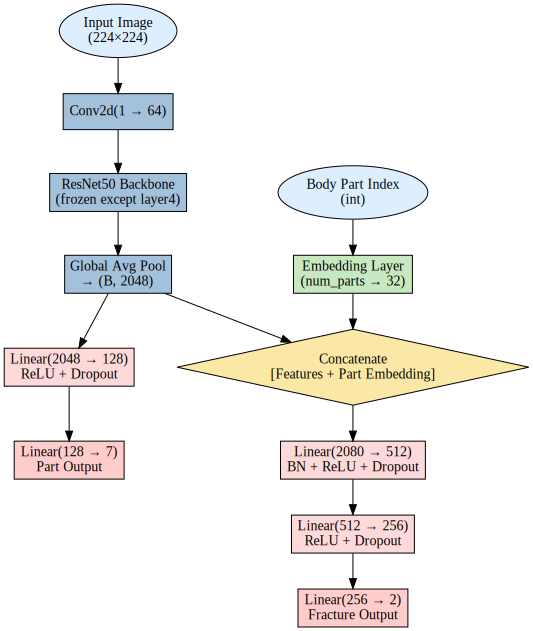

In [ ]:
display(resnet_diagram)